## Supermarket store branches sales analysis
https://www.kaggle.com/datasets/surajjha101/stores-area-and-sales-data

At the end of this project, I'll try to predict the Store Sales of Supermarket Store Branches

In [101]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [102]:
df = pd.read_csv('Stores.csv')

In [103]:
df.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1,1659,1961,530,66490
1,2,1461,1752,210,39820
2,3,1340,1609,720,54010
3,4,1451,1748,620,53730
4,5,1770,2111,450,46620


In [104]:
# There're only numeric variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Store ID              896 non-null    int64
 1   Store_Area            896 non-null    int64
 2   Items_Available       896 non-null    int64
 3   Daily_Customer_Count  896 non-null    int64
 4   Store_Sales           896 non-null    int64
dtypes: int64(5)
memory usage: 35.1 KB


In [105]:
# There is no NaN
df.isna().sum()

Store ID                0
Store_Area              0
Items_Available         0
Daily_Customer_Count    0
Store_Sales             0
dtype: int64

In [106]:
df.describe()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
count,896.000000,896.000000,896.000000,896.000000,896.000000
mean,448.500000,1485.409598,1782.035714,786.350446,59351.305804
std,258.797218,250.237011,299.872053,265.389281,17190.741895
min,1.000000,775.000000,932.000000,10.000000,14920.000000
25%,224.750000,1316.750000,1575.500000,600.000000,46530.000000
50%,448.500000,1477.000000,1773.500000,780.000000,58605.000000
75%,672.250000,1653.500000,1982.750000,970.000000,71872.500000
max,896.000000,2229.000000,2667.000000,1560.000000,116320.000000


In [107]:
# There's one branch that only has 10 daily customers. This value seems is to be too low in comparison with the mean,
# so it might be an outlier
df.Daily_Customer_Count.nsmallest(5)

39      10
151     70
876    100
230    120
146    130
Name: Daily_Customer_Count, dtype: int64

In [108]:
# Getting the z-score of that value. 
# It'll be considered an outlier if the zscore is greater than |3|
stats.zscore(df.Daily_Customer_Count)[39]

-2.926960872097397

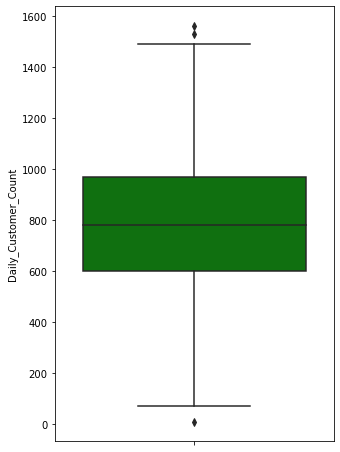

In [109]:
# Checking wheter the 10 daily consumers is really too low or an accetable value.
# It's not very far from the last percentile, so I'll keep it.
plt.figure(figsize=(5,8))
sns.boxplot(data = df , y = 'Daily_Customer_Count', color = 'green');

In [110]:
# Visualizing the other columns in the line where the daily costumer is 10 to check if they seem ok, only to confirm.
# All the other lines show regular values.
df.loc[39]


Store ID                   40
Store_Area               1270
Items_Available          1516
Daily_Customer_Count       10
Store_Sales             45480
Name: 39, dtype: int64

In [111]:
# There is no duplicated values.
df.duplicated().sum()

0

In [112]:
df.columns

Index(['Store ID ', 'Store_Area', 'Items_Available', 'Daily_Customer_Count',
       'Store_Sales'],
      dtype='object')

In [113]:
# Taking the black space out of the first column name ('Store ID').
df.columns = df.columns.str.replace(df.columns[0], df.columns[0][:-1])

In [114]:
df.columns

Index(['Store ID', 'Store_Area', 'Items_Available', 'Daily_Customer_Count',
       'Store_Sales'],
      dtype='object')

In [115]:
# Setting Store ID as index
df.set_index(['Store ID'])

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
Store ID,,,,
1,1659,1961,530,66490
2,1461,1752,210,39820
3,1340,1609,720,54010
4,1451,1748,620,53730
5,1770,2111,450,46620
...,...,...,...,...
892,1582,1910,1080,66390
893,1387,1663,850,82080
894,1200,1436,1060,76440


# Variable Analysis:
- Compare the variables with the target variable 'Store_Sales'


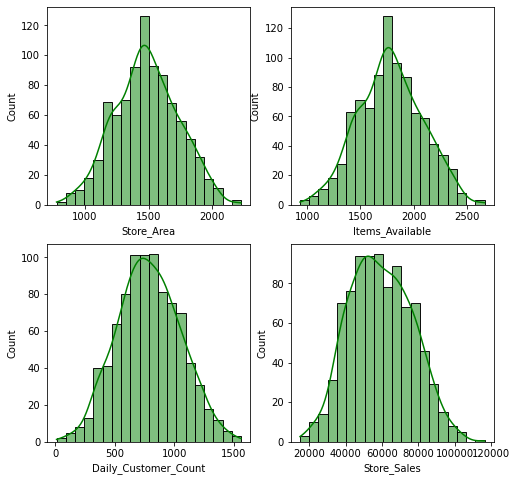

In [116]:
# Plotting a histogram to all the variables of the dataset
# They alll have a normal distribution
plt.figure(figsize = (8,8))

for i in range(1, len(df.columns)):
    plt.subplot(2, 2, i)
    sns.histplot(data = df, x = df.columns[i], bins = 20, color = 'green', kde = True)

In [117]:
# Variables Correlation
corr_df = df[df.columns].corr()

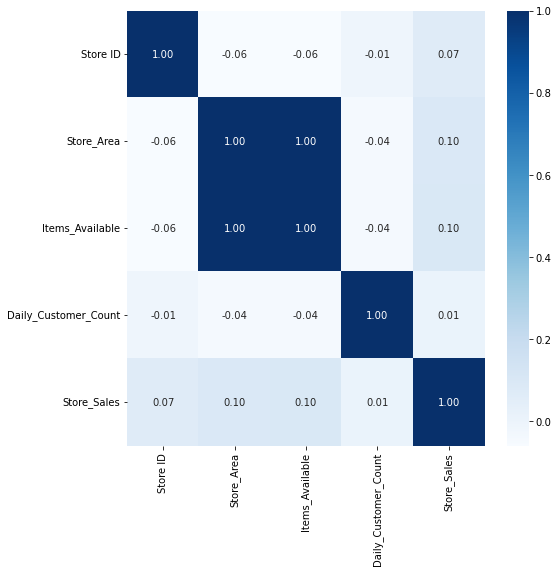

In [118]:
# Heatmap
# It's possible to see that Store_Area and Item_avaliable is totally positive related(1.0). 
# Even tough it's suspicious to have such a positive relation, it makes sense, since the more itens a supermarket has,
# the more area is needed
# The others variables are not much related.
plt.figure(figsize=(8,8))

sns.heatmap(data = corr_df, cmap = 'Blues', annot = True, fmt = '.2f')

*Decision*: We might take a decision here to only apply Feature Engineering in variables which the correlation is >=  0.10
('Daily_Customer_Count' won't be used to train the algorithm)

In [119]:
df.columns

Index(['Store ID', 'Store_Area', 'Items_Available', 'Daily_Customer_Count',
       'Store_Sales'],
      dtype='object')

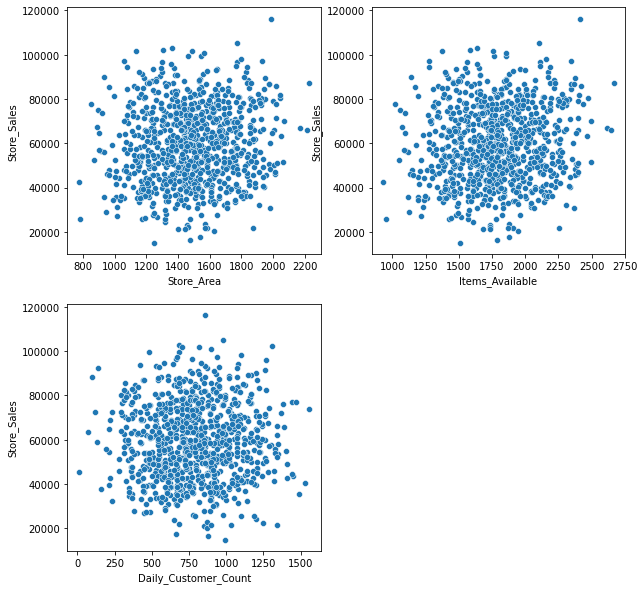

In [120]:
# Comparing the variables with the the Store Sales using a scatterplot
plt.figure(figsize=(10,10))

for i in range(1, len(df.columns)-1):
    plt.subplot(2,2, i)
    sns.scatterplot(data = df, x = df.columns[i], y = 'Store_Sales');

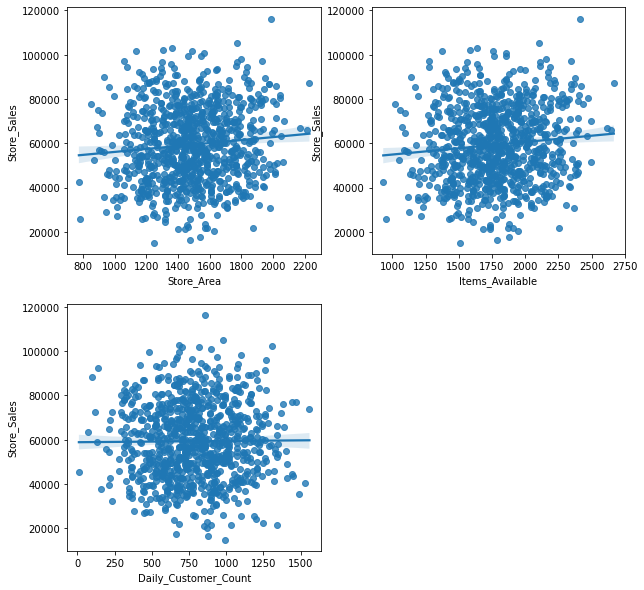

In [121]:
# Regression plot
# It's able to see more clearly the relation between the variables and the Store Sales
plt.figure(figsize=(10,10))

for i in range(1,len(df.columns)-1):
    plt.subplot(2,2,i)
    sns.regplot(data = df, x = df.columns[i], y='Store_Sales')

> Conclusion: The 'Store_Area' and 'Items_Available' area have a slight positive relation with the target variable 'Store_Sales'

**Feature Engineering**

In [122]:
df_eng = df.copy()

In [123]:
df_eng.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1,1659,1961,530,66490
1,2,1461,1752,210,39820
2,3,1340,1609,720,54010
3,4,1451,1748,620,53730
4,5,1770,2111,450,46620


In [124]:
df_eng.describe()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
count,896.000000,896.000000,896.000000,896.000000,896.000000
mean,448.500000,1485.409598,1782.035714,786.350446,59351.305804
std,258.797218,250.237011,299.872053,265.389281,17190.741895
min,1.000000,775.000000,932.000000,10.000000,14920.000000
25%,224.750000,1316.750000,1575.500000,600.000000,46530.000000
50%,448.500000,1477.000000,1773.500000,780.000000,58605.000000
75%,672.250000,1653.500000,1982.750000,970.000000,71872.500000
max,896.000000,2229.000000,2667.000000,1560.000000,116320.000000


In [125]:
# The variable 'Store_Area' and 'Items_Available' will be put in bins
bin1 = [0, 1250, 1750, 2250]
label_bin1 = ['<1250m²', '1250-1749m²', '1750-2250m²']
bin2 = [0, 1300, 1800, 2300, 2800]
label_bin2 = ['<1300','1300-1799','1800-2299', '2300-2800']

In [126]:
df_eng['Store_Area_bins'] = pd.cut(df_eng['Store_Area'],
                                    bins = bin1,
                                    labels=label_bin1,
                                    )

In [127]:
df_eng.Store_Area_bins.value_counts()

1250-1749m²    572
<1250m²        178
1750-2250m²    146
Name: Store_Area_bins, dtype: int64

In [128]:
df_eng.sample(10)

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,Store_Area_bins
282,283,1533,1848,1070,56440,1250-1749m²
132,133,1396,1672,1170,50070,1250-1749m²
355,356,1269,1511,500,54360,1250-1749m²
797,798,1536,1808,830,56380,1250-1749m²
724,725,1493,1795,530,62380,1250-1749m²
795,796,1440,1747,1090,67320,1250-1749m²
739,740,1358,1645,770,56860,1250-1749m²
420,421,1161,1404,430,58380,<1250m²
280,281,1270,1515,720,60240,1250-1749m²
436,437,1744,2101,520,69570,1250-1749m²


In [129]:
df_eng['Items_Available_bins'] = pd.cut(df_eng['Items_Available'],
                                                bins = bin2,
                                                labels = label_bin2)

In [130]:
df_eng.Items_Available_bins.value_counts()

1300-1799    437
1800-2299    372
<1300         47
2300-2800     40
Name: Items_Available_bins, dtype: int64

In [131]:
df_eng.sample(8)

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,Store_Area_bins,Items_Available_bins
590,591,1206,1437,1330,54060,<1250m²,1300-1799
211,212,1488,1807,1030,70810,1250-1749m²,1800-2299
373,374,1909,2306,820,31940,1750-2250m²,2300-2800
832,833,1330,1606,590,38510,1250-1749m²,1300-1799
534,535,1381,1634,930,30790,1250-1749m²,1300-1799
593,594,1624,1946,870,20270,1250-1749m²,1800-2299
380,381,1599,1946,940,78090,1250-1749m²,1800-2299
96,97,1853,2235,1120,60960,1750-2250m²,1800-2299


In [132]:
# They've become categorical
new_columns = ['Items_Available_bins', 'Store_Area_bins']

In [133]:
df_report1 = df_eng.groupby(['Store_Area_bins']).agg({'Store_Sales':['mean']}).reset_index()
df_report1

,Store_Area_bins,Store_Sales
,,mean
0,<1250m²,56983.820225
1,1250-1749m²,59247.657343
2,1750-2250m²,62643.767123


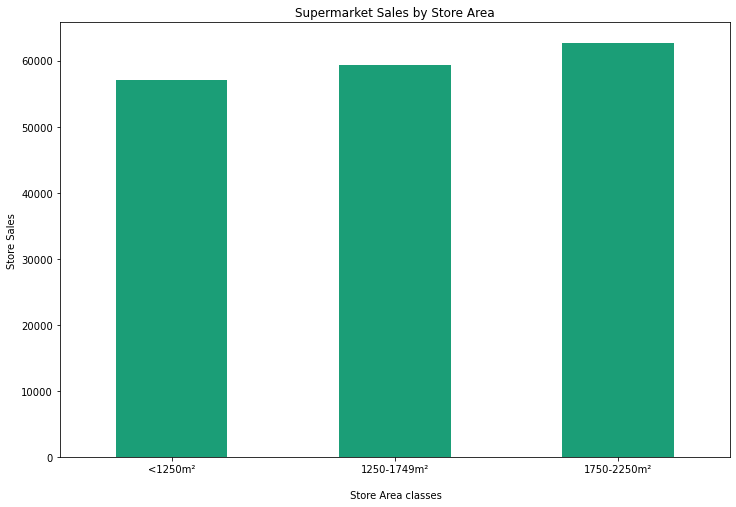

In [134]:
df_report1.set_index('Store_Area_bins').plot(kind = 'bar',
                                             title = 'Supermarket Sales by Store Area',
                                             xlabel = '\n Store Area classes',
                                             ylabel = 'Store Sales',
                                             figsize = (12,8),
                                             colormap = 'Dark2',
                                             legend = '')
plt.xticks(rotation = 0)
plt.show()

>Conclusion: It's possible to saythat the Store Area has a slight positive relation in the Store Sales 

In [135]:
df_report2 = df_eng.groupby(['Items_Available_bins']).agg({'Store_Sales':['mean']}).reset_index()
df_report2

,Items_Available_bins,Store_Sales
,,mean
0,<1300,54998.936170
1,1300-1799,58641.556064
2,1800-2299,59944.784946
3,2300-2800,66700.000000


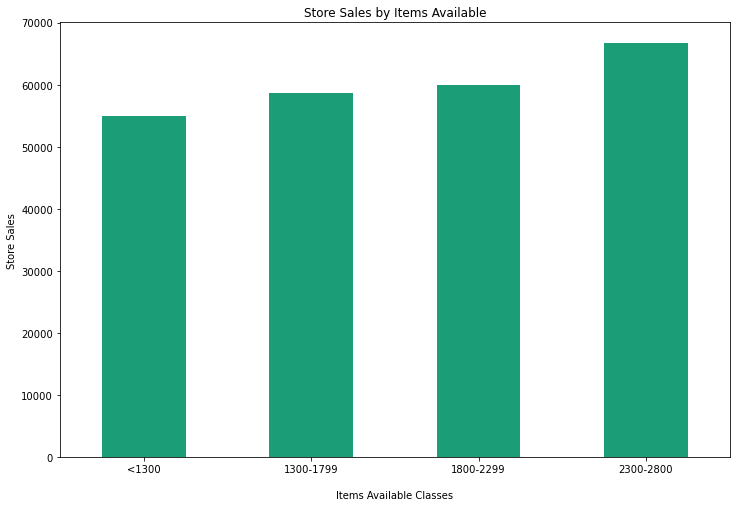

In [136]:
df_report2.set_index('Items_Available_bins').plot(kind = 'bar',
                                                  title = 'Store Sales by Items Available',
                                                  xlabel = '\nItems Available Classes',
                                                  ylabel = 'Store Sales',
                                                  figsize = (12,8),
                                                  colormap = 'Dark2',
                                                  legend = '')
plt.xticks(rotation = 0)
plt.show()

>Conclusion: It's possible to say that the 'Items Available' has a slight positive relation in the Store Sales 

**Comparing the quantity of itens available with the Store Area**

In [137]:
df_eng.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,Store_Area_bins,Items_Available_bins
0,1,1659,1961,530,66490,1250-1749m²,1800-2299
1,2,1461,1752,210,39820,1250-1749m²,1300-1799
2,3,1340,1609,720,54010,1250-1749m²,1300-1799
3,4,1451,1748,620,53730,1250-1749m²,1300-1799
4,5,1770,2111,450,46620,1750-2250m²,1800-2299


In [138]:
df_report3 = df_eng.groupby(['Items_Available_bins']).agg({'Store_Area':['mean']}).reset_index()
df_report3

,Items_Available_bins,Store_Area
,,mean
0,<1300,989.148936
1,1300-1799,1334.324943
2,1800-2299,1670.741935
3,2300-2800,1995.525000


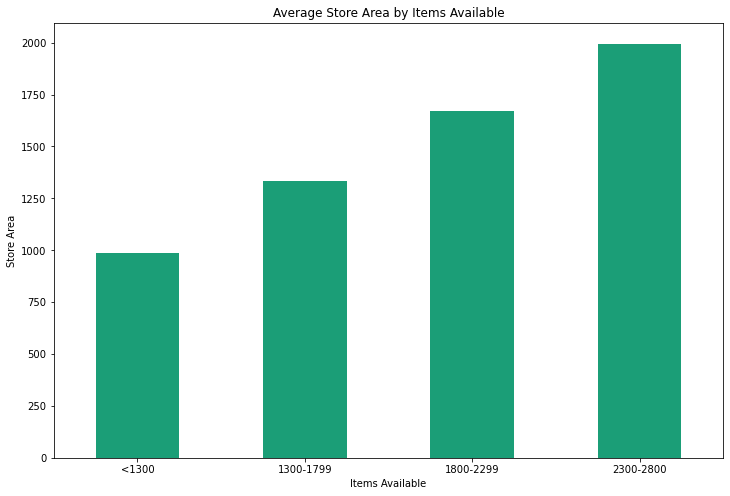

In [139]:
df_report3.set_index('Items_Available_bins').plot(kind = 'bar',
                                                  title = 'Average Store Area by Items Available',
                                                  xlabel = 'Items Available',
                                                  ylabel = 'Store Area',
                                                  colormap = 'Dark2',
                                                  figsize = (12,8),
                                                  legend = '')
plt.xticks(rotation = 0)
plt.show()

**Comparing the Store Area with the number of Daily Customer**

In [140]:
df_report4 = df_eng.groupby(['Store_Area_bins']).agg({'Daily_Customer_Count':'mean'}).reset_index()
df_report4

,Store_Area_bins,Daily_Customer_Count
0,<1250m²,816.292135
1,1250-1749m²,776.520979
2,1750-2250m²,788.356164


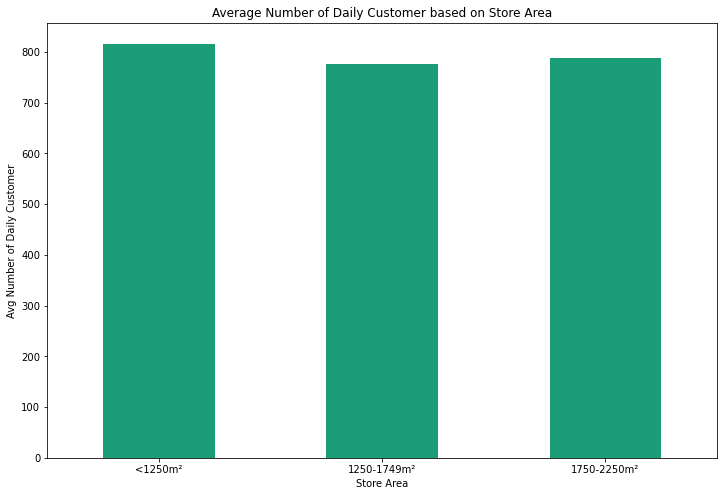

In [141]:
df_report4.set_index('Store_Area_bins').plot(kind = 'bar',
                                             title = 'Average Number of Daily Customer based on Store Area',
                                             xlabel = 'Store Area',
                                             ylabel = 'Avg Number of Daily Customer',
                                             figsize = (12,8),
                                             colormap = 'Dark2',
                                             legend = '')
plt.xticks(rotation = 0)
plt.show()

*Conclusion:* The Store area doesn't seem to have relation with the number of Daily Customer

## Pre-Processing

In [142]:
# Reorganizing the dataset
df_eng.insert(3,'Items_Available_bins', df_eng.pop('Items_Available_bins'))
df_eng.insert(2, 'Store_Area_bins', df_eng.pop('Store_Area_bins'))

In [143]:
df_eng.head()

,Store ID,Store_Area,Store_Area_bins,Items_Available,Items_Available_bins,Daily_Customer_Count,Store_Sales
0,1,1659,1250-1749m²,1961,1800-2299,530,66490
1,2,1461,1250-1749m²,1752,1300-1799,210,39820
2,3,1340,1250-1749m²,1609,1300-1799,720,54010
3,4,1451,1250-1749m²,1748,1300-1799,620,53730
4,5,1770,1750-2250m²,2111,1800-2299,450,46620
